In [74]:
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

# 解决绘图的兼容问题
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题

In [75]:
pd.__version__

'2.0.3'

### 处理评论数据的主要步骤
#### 加载数据

In [76]:
df = pd.read_csv('stopwords_comments.csv')

In [77]:
# 先移除空值
df.dropna(subset=['评论内容'], inplace=True)

# 强制将评论内容转换为字符串类型
df['评论内容'] = df['评论内容'].astype(str)

#### 添加情感分析结果

In [78]:
from snownlp import SnowNLP

df['情感分数'] = df['评论内容'].apply(lambda x: SnowNLP(x).sentiments)

#### 分析感情分数与评分之间的关系

In [79]:
avg_sentiment_per_rating = df.groupby('评分')['情感分数'].mean()

print(avg_sentiment_per_rating)

评分
1    0.185271
2    0.265159
3    0.411645
4    0.669627
5    0.877035
Name: 情感分数, dtype: float64


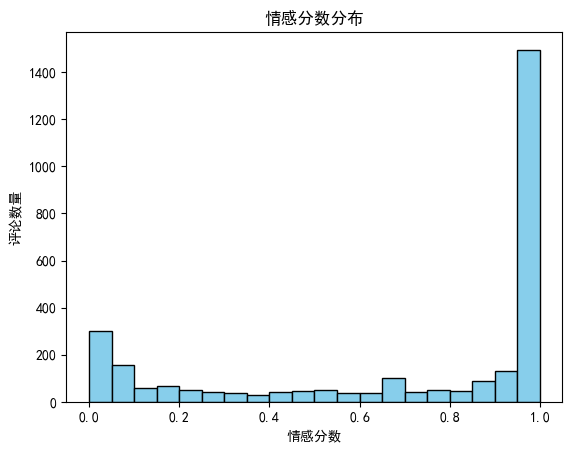

In [80]:
plt.hist(df['情感分数'], bins=20, color='skyblue', edgecolor='black')
plt.title('情感分数分布')
plt.xlabel('情感分数')
plt.ylabel('评论数量')
plt.show()

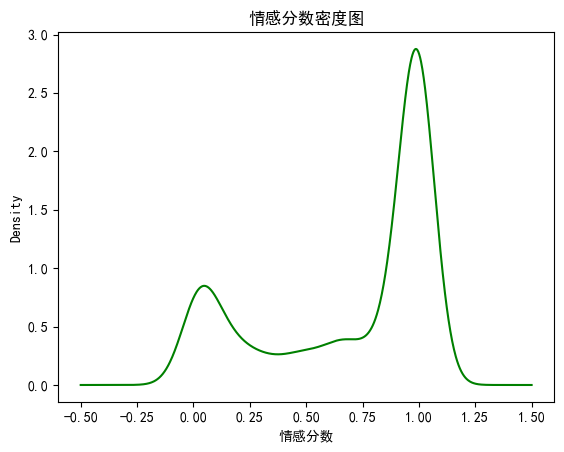

In [81]:
df['情感分数'].plot(kind='density', color='green')
plt.title('情感分数密度图')
plt.xlabel('情感分数')
plt.show()

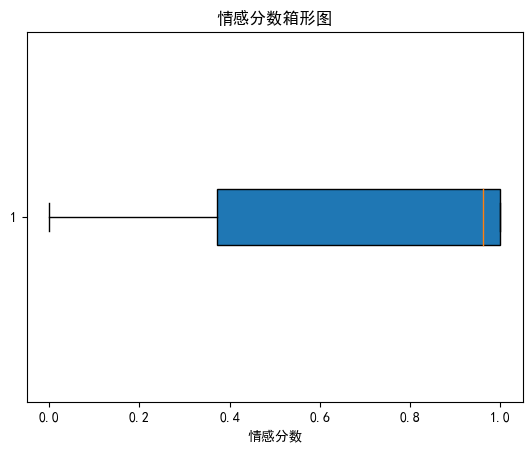

In [85]:
plt.boxplot(df['情感分数'], vert=False, patch_artist=True)
plt.title('情感分数箱形图')
plt.xlabel('情感分数')
plt.show()


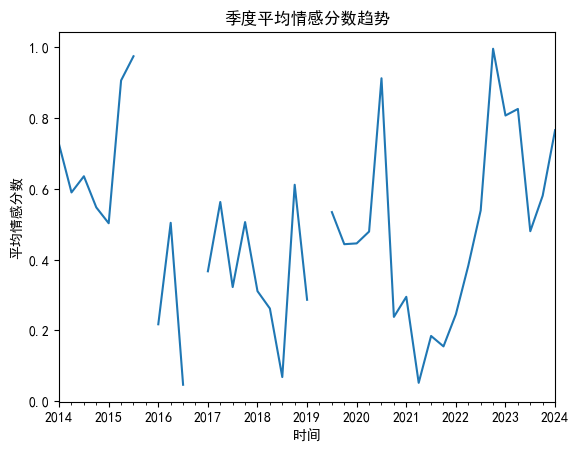

In [90]:
# 按季度汇总情感分数平均值
quarterly_sentiment = df['情感分数'].resample('Q').mean()

quarterly_sentiment.plot()
plt.title('季度平均情感分数趋势')
plt.xlabel('时间')
plt.ylabel('平均情感分数')
plt.show()


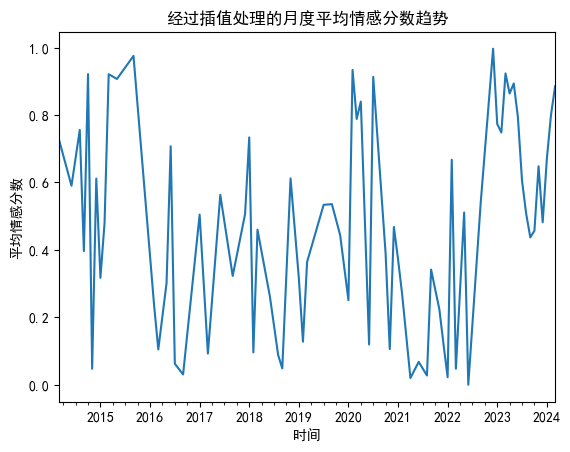

In [91]:
# 先按月汇总，然后对缺失月份进行线性插值
monthly_sentiment = df['情感分数'].resample('M').mean().interpolate(method='linear')

monthly_sentiment.plot()
plt.title('经过插值处理的月度平均情感分数趋势')
plt.xlabel('时间')
plt.ylabel('平均情感分数')
plt.show()


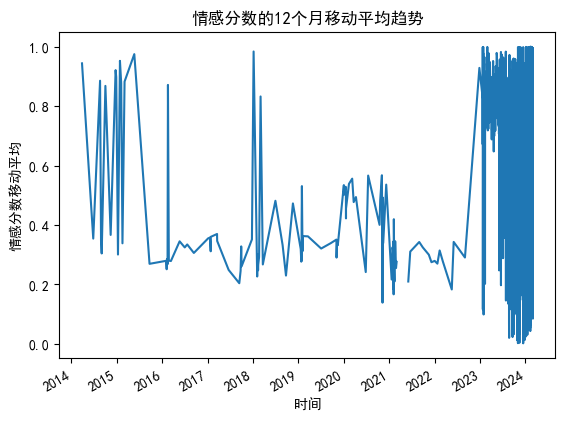

In [92]:
# 计算12个月移动平均
rolling_sentiment = df['情感分数'].rolling(window=12, center=True).mean()

rolling_sentiment.plot()
plt.title('情感分数的12个月移动平均趋势')
plt.xlabel('时间')
plt.ylabel('情感分数移动平均')
plt.show()


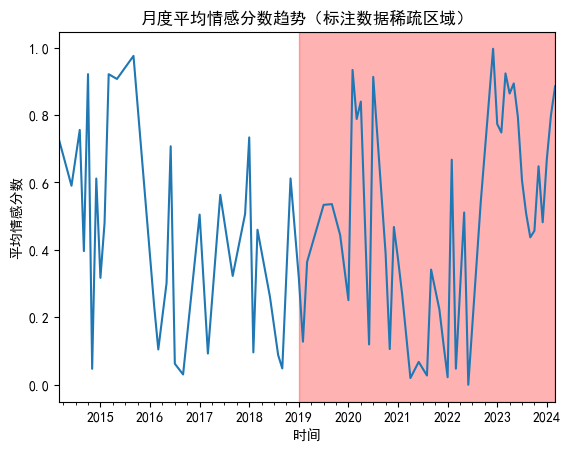

In [93]:
monthly_sentiment.plot()
plt.title('月度平均情感分数趋势（标注数据稀疏区域）')
plt.xlabel('时间')
plt.ylabel('平均情感分数')

# 假设2019年之后数据稀疏，用红色背景标注
plt.axvspan('2019-01-01', df.index.max(), color='red', alpha=0.3)

plt.show()

### 实现单独比较
#### 按时间线划分

In [87]:
# 假设df是你的DataFrame，且已经有一个名为“评论时间”的日期时间列
# 假设 df 已经按照 "评论时间" 列进行了排序
df['评论时间'] = pd.to_datetime(df['评论时间'])

# 分段条件
split_date = pd.Timestamp('2019-01-01')

# 分段，并创建副本
before_2019 = df[df['评论时间'] < split_date].copy()
after_2019 = df[df['评论时间'] >= split_date].copy()

#### 分别进行情感分析

In [88]:
# 对每个分段的数据应用情感分析
before_2019['情感分数'] = before_2019['评论内容'].apply(lambda x: SnowNLP(x).sentiments)
after_2019['情感分数'] = after_2019['评论内容'].apply(lambda x: SnowNLP(x).sentiments)

# 确保 '评论时间' 列是日期时间格式
before_2019['评论时间'] = pd.to_datetime(before_2019['评论时间'])
after_2019['评论时间'] = pd.to_datetime(after_2019['评论时间'])


In [89]:
# 将 '评论时间' 设置为索引
before_2019.set_index('评论时间', inplace=True)
after_2019.set_index('评论时间', inplace=True)
df.set_index('评论时间', inplace=True)

# 现在可以进行 resample 操作
before_2019_mean_sentiment = before_2019['情感分数'].resample('M').mean()
after_2019_mean_sentiment = after_2019['情感分数'].resample('M').mean()


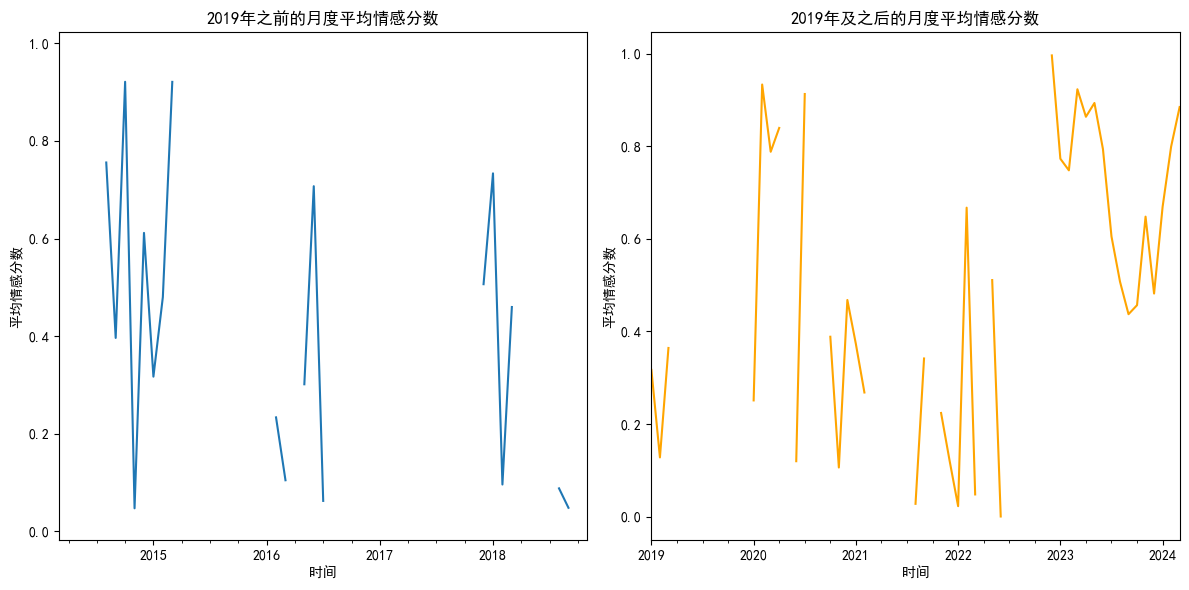

In [94]:
# 绘制
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 两个子图中的第一个
before_2019_mean_sentiment.plot(title='2019年之前的月度平均情感分数')
plt.xlabel('时间')
plt.ylabel('平均情感分数')

plt.subplot(1, 2, 2)  # 两个子图中的第二个
after_2019_mean_sentiment.plot(title='2019年及之后的月度平均情感分数', color='orange')
plt.xlabel('时间')
plt.ylabel('平均情感分数')

plt.tight_layout()
plt.show()

### 分析和对比情感分数

#### 计算情感分数统计数据

In [95]:
# 计算统计数据
before_2019_stats = before_2019['情感分数'].describe()
after_2019_stats = after_2019['情感分数'].describe()

print("2019年之前的情感分数统计：\n", before_2019_stats)
print("\n2019年及之后的情感分数统计：\n", after_2019_stats)


2019年之前的情感分数统计：
 count    55.000000
mean      0.393722
std       0.314551
min       0.000066
25%       0.085575
50%       0.396421
75%       0.635373
max       0.975135
Name: 情感分数, dtype: float64

2019年及之后的情感分数统计：
 count    2845.000000
mean        0.711348
std         0.377862
min         0.000000
25%         0.398251
50%         0.966704
75%         0.999562
max         1.000000
Name: 情感分数, dtype: float64


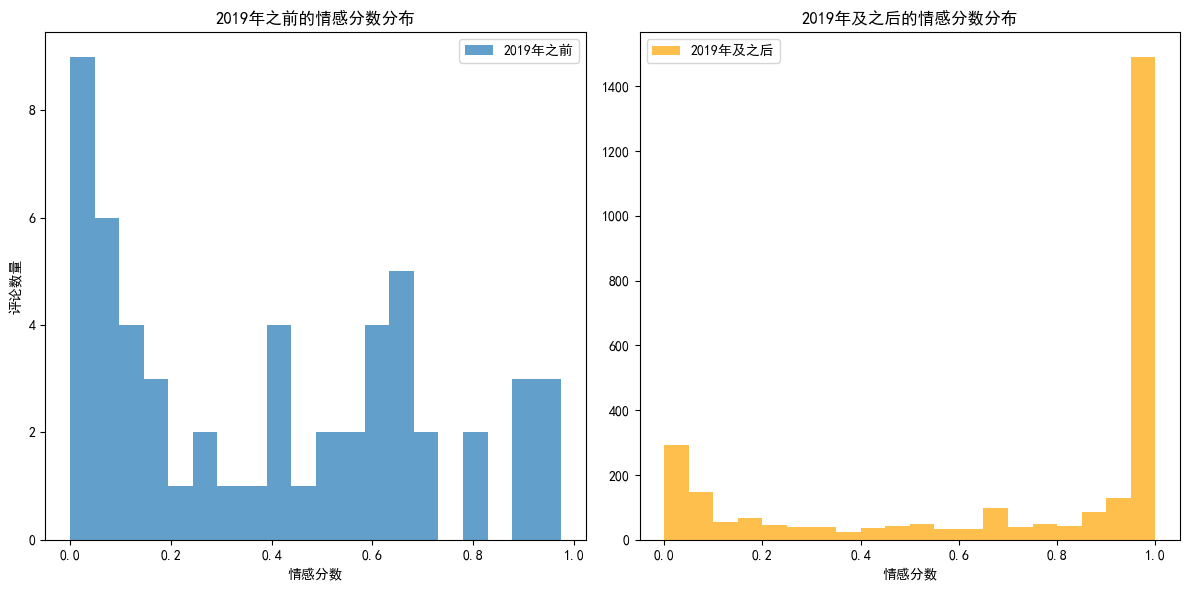

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(before_2019['情感分数'], bins=20, alpha=0.7, label='2019年之前')
plt.xlabel('情感分数')
plt.ylabel('评论数量')
plt.title('2019年之前的情感分数分布')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(after_2019['情感分数'], bins=20, alpha=0.7, color='orange', label='2019年及之后')
plt.xlabel('情感分数')
plt.title('2019年及之后的情感分数分布')
plt.legend()

plt.tight_layout()
plt.show()

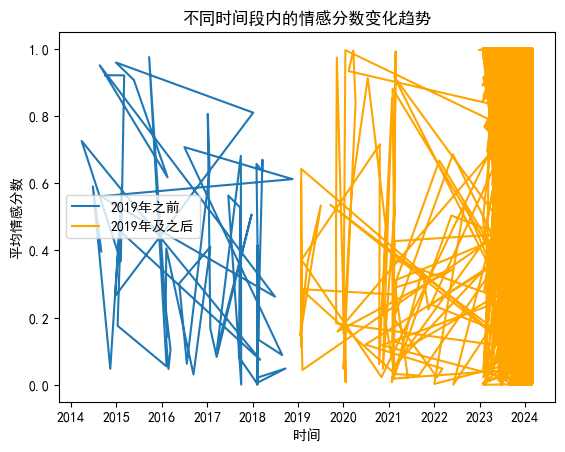

In [97]:
# 假设before_2019和after_2019已经按月聚合了情感分数的平均值
plt.plot(before_2019.index, before_2019['情感分数'], label='2019年之前')
plt.plot(after_2019.index, after_2019['情感分数'], label='2019年及之后', color='orange')

plt.xlabel('时间')
plt.ylabel('平均情感分数')
plt.title('不同时间段内的情感分数变化趋势')
plt.legend()
plt.show()


In [98]:
# 停用词表是多个文本文件，每行一个停用词。
def load_stopwords(stopwords_paths):
    stopwords = set()
    for path in stopwords_paths:
        with open(path, 'r', encoding='utf-8') as file:
            for line in file:
                stopwords.add(line.strip())  # 去除可能的空格和换行符，然后添加到集合中
    return stopwords

# 过遍历文本中的每个词并检查它是否在停用词集合中来去除停用词。
def remove_stopwords(text, stopwords):
    words = text.split()  # 分词
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

# 停用词表的路径列表
stopwords_paths = ['baidu_stopwords.txt', 'cn_stopwords.txt', 'hit_stopwords.txt', 'scu_stopwords.txt']
stopwords = load_stopwords(stopwords_paths)

# 加载停用词
stopwords_list = list(stopwords)  # 将集合转换为列表


In [104]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# 假设 stopwords_list 是你的原始停用词列表
# 预处理停用词列表
preprocessed_stopwords = [word.lower().strip() for word in stopwords_list]  # 小写化并去除空白

# 确保去除包含特殊字符的停用词
preprocessed_stopwords = [word for word in preprocessed_stopwords if word.isalnum()]

# 使用预处理后的停用词列表
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=preprocessed_stopwords)


X = vectorizer.fit_transform(df['评论内容'])

# 应用LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

# 查看主题
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"主题 #{topic_idx+1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))

主题 #1:
hellip 京东 好酒 打开 降价 客服 大气 不好 高端 包装
主题 #2:
不错 泸州老窖 好喝 京东 差评 价格 上头 味道 活动 喜欢
主题 #3:
泸州老窖 口感 白酒 入口 头曲 六年 口粮 购买 京东 值得
主题 #4:
包装 口感 物流 不错 送礼 设计 速度 京东 过年 服务
主题 #5:
不错 购买 包装 满意 价格 质量 物流 很快 喜欢 收到


In [100]:
from sklearn.cluster import KMeans

# 假设我们基于TF-IDF特征进行聚类
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
df['聚类标签'] = kmeans.labels_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


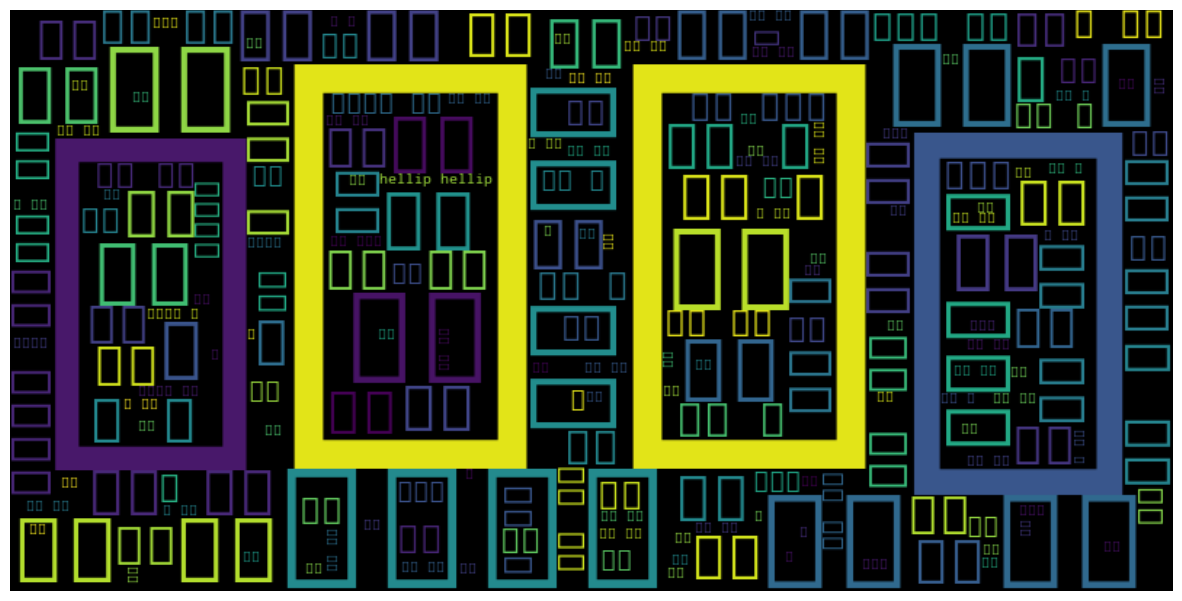

In [103]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 生成整个数据集的词云
text = ' '.join(df['评论内容'])
wordcloud f= WordCloud(width=800, height=400).generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


聚类算法中，不同的算法基于不同的数学原理和公式。以下是一些常见聚类算法的核心公式和原理简述：

### 1. K-means聚类
K-means算法的目标是最小化每个点到其簇中心的距离的平方和，其目标函数公式为：
\[ J = \sum_{i=1}^{k} \sum_{x \in S_i} ||x - \mu_i||^2 \]
其中，\(k\) 是簇的数量，\(S_i\) 是第 \(i\) 个簇中所有点的集合，\(x\) 是簇 \(S_i\) 中的点，\(\mu_i\) 是簇 \(S_i\) 的中心点，\(||x - \mu_i||^2\) 是点 \(x\) 到簇中心 \(\mu_i\) 的欧氏距离的平方。

### 2. 层次聚类
层次聚类没有一个统一的目标函数，它通过计算数据点之间的相似度或距离，并根据这些距离逐步合并或分裂簇。距离或相似度的度量方法包括：

- 单链接（最近邻）：\(d(S_i, S_j) = \min \{d(x, y) | x \in S_i, y \in S_j\}\)
- 完全链接（最远邻）：\(d(S_i, S_j) = \max \{d(x, y) | x \in S_i, y \in S_j\}\)
- 平均链接：\(d(S_i, S_j) = \frac{1}{|S_i||S_j|}\sum_{x \in S_i}\sum_{y \in S_j} d(x, y)\)
- 质心链接：\(d(S_i, S_j) = ||\mu_i - \mu_j||\)

其中，\(d(x, y)\) 表示点 \(x\) 和点 \(y\) 之间的距离，\(\mu_i\) 和 \(\mu_j\) 分别是簇 \(S_i\) 和 \(S_j\) 的中心点。

### 3. DBSCAN（Density-Based Spatial Clustering of Applications with Noise）
DBSCAN算法不直接基于一个优化的目标函数，而是通过两个参数：半径 \(\epsilon\) 和最小点数 \(MinPts\)，来识别簇的密集区域。点 \(x\) 的 \(\epsilon\)-邻域表示为：
\[ N_{\epsilon}(x) = \{y \in D | ||y - x|| \leq \epsilon\} \]
其中，\(D\) 是数据集，\(||y - x||\) 是点 \(y\) 到点 \(x\) 的距离。

### 4. 谱聚类
谱聚类算法基于图论，主要操作是对图的拉普拉斯矩阵 \(L\) 进行特征分解。拉普拉斯矩阵定义为 \(L = D - W\)，其中 \(W\) 是图的相似度（或权重）矩阵，\(D\) 是度矩阵，对角线上的元素 \(D_{ii}\) 是点 \(i\) 的度（即所有连接到点 \(i\) 的边的权重之和）。谱聚类的目标是最小化图切割的成本，具体的数学表达式较为复杂，涉及到图的分割理论和矩阵的特征值问题。

这些算法的核心原理和公式各有侧重，选择哪一种算法通常取决于数据的特性及应用场景的需求。

一个词的TF-IDF值是通过将该词的词频(TF)值与其逆文档频率(IDF)值相乘得到的。具体的数学公式如下：

### 词频（TF，Term Frequency）

\[ \text{TF}(t, d) = \frac{f_{t, d}}{\sum_{t' \in d} f_{t', d}} \]

- 其中，\(f_{t, d}\) 是词 \(t\) 在文档 \(d\) 中的出现次数。
- 分母是文档 \(d\) 中所有词的出现次数之和。

### 逆文档频率（IDF，Inverse Document Frequency）

\[ \text{IDF}(t, D) = \log \left( \frac{N}{n_t} \right) \]

- \(N\) 是文档集合 \(D\) 中文档的总数。
- \(n_t\) 是包含词 \(t\) 的文档数目。如果词不在数据集中，将导致分母为零，因此一般会加1以避免这个问题，即使用 \(\log \left( \frac{N}{n_t + 1} \right)\)。

### TF-IDF

结合上述两个公式，一个词 \(t\) 在文档 \(d\) 中的TF-IDF值计算如下：

\[ \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D) \]

- \(\text{TF-IDF}(t, d, D)\) 表示词 \(t\) 在文档 \(d\) 中的重要性，它考虑了词 \(t\) 在整个文档集合 \(D\) 中的稀有程度。

这种计算方法使得那些在特定文档中频繁出现，但在整个文档集合中较少出现的词语被认为是重要的。这样可以过滤掉常见的词汇，如停用词，它们在大多数文档中都会出现，但对于区分文档的主题或内容没有太大帮助。